ProcessPool-formate data - provided data from jainils script

In [ ]:
def create_dir_structure(base_dir, categories, subfolders):
    for category in categories:
        for subfolder in subfolders:
            path = os.path.join(base_dir, category, subfolder, 'images')
            os.makedirs(path, exist_ok=True)
            path = os.path.join(base_dir, category, subfolder, 'labels')
            os.makedirs(path, exist_ok=True)

def copy_files(src_image_path, dest_image_path, src_label_path, dest_label_path):
    shutil.copy(src_image_path, dest_image_path)
    shutil.copy(src_label_path, dest_label_path)

def split_data(src_dir, dest_dir, categories, split_ratio):
    with ProcessPoolExecutor(max_workers=50) as executor:  # Adjust max_workers as per your CPU cores
        for category in categories:
            images = [f for f in os.listdir(os.path.join(src_dir, category, 'images')) if os.path.isfile(os.path.join(src_dir, category, 'images', f))]
            labels = [f for f in os.listdir(os.path.join(src_dir, category, 'labels')) if os.path.isfile(os.path.join(src_dir, category, 'labels', f))]

            combined = list(zip(images, labels))
            random.shuffle(combined)
            images[:], labels[:] = zip(*combined)

            num_images = len(images)
            train_split = int(split_ratio[0] * num_images)
            test_split = int(split_ratio[1] * num_images) + train_split

            datasets = {
                'train': (images[:train_split], labels[:train_split]),
                'test': (images[train_split:test_split], labels[train_split:test_split]),
                'val': (images[test_split:], labels[test_split:])
            }

            for dataset in datasets:
                for image, label in zip(datasets[dataset][0], datasets[dataset][1]):
                    src_image_path = os.path.join(src_dir, category, 'images', image)
                    dest_image_path = os.path.join(dest_dir, category, dataset, 'images', image)

                    src_label_path = os.path.join(src_dir, category, 'labels', label)
                    dest_label_path = os.path.join(dest_dir, category, dataset, 'labels', label)

                    executor.submit(copy_files, src_image_path, dest_image_path, src_label_path, dest_label_path)

def main():
    src_dir = '/mnt/storage/backup/label_wise_jainil/'
    dest_dir = '/home/research/kilasar_sentinal_wepon_detection/data'
    categories = ['0', '1', '2', 'n']  # Specifying the 4 categories
    subfolders = ['train', 'test', 'val']
    split_ratio = (0.8, 0.1, 0.1)  # 80% train, 10% test, 10% validation

    create_dir_structure(dest_dir, categories, subfolders)
    split_data(src_dir, dest_dir, categories, split_ratio)

if __name__ == "__main__":
    main()


create subset from a large dataset in yolo

In [ ]:
import os
import shutil
from multiprocessing import Pool

def copy_file(pair):
    src, dest = pair
    shutil.copy(src, dest)

def create_subset(images_dir, labels_dir, subset_size, num_processes, subset_location):
    # Create a list of image files and corresponding label files
    image_files = sorted(os.listdir(images_dir))
    label_files = sorted(os.listdir(labels_dir))

    # Select the first subset_size files
    image_files_subset = image_files[:subset_size]
    label_files_subset = label_files[:subset_size]

    # Create subset directory if it doesn't exist
    subset_images_dir = os.path.join(subset_location, 'images')
    subset_labels_dir = os.path.join(subset_location, 'labels')
    os.makedirs(subset_images_dir, exist_ok=True)
    os.makedirs(subset_labels_dir, exist_ok=True)

    # Prepare source and destination paths for copying
    image_pairs = [(os.path.join(images_dir, img), os.path.join(subset_images_dir, img)) for img in image_files_subset]
    label_pairs = [(os.path.join(labels_dir, lbl), os.path.join(subset_labels_dir, lbl)) for lbl in label_files_subset]

    # Use multiprocessing Pool with specified number of processes
    with Pool(processes=num_processes) as pool:
        pool.map(copy_file, image_pairs)
        pool.map(copy_file, label_pairs)


# Define paths and parameters
images_directory = "/home/research/kilasar_sentinal_wepon_detection/data/n/val/images"
labels_directory = "/home/research/kilasar_sentinal_wepon_detection/data/n/val/labels"
subset_size = 1200
num_processes = 60  # Adjust this number based on your system's capabilities
subset_location = "/home/research/kilasar_sentinal_wepon_detection/suryansh/data/n/val"  # Specify the location for the subset

# Create the subset
create_subset(images_directory, labels_directory, subset_size, num_processes, subset_location)


In [ ]:
import os
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from ultralytics import YOLO
import torch

def calculate_accuracy(model, data_dir, split='train'):
    y_true = []
    y_pred = []
    for class_idx in range(3):  # Adjust based on your actual class directories
        image_folder = os.path.join(data_dir, str(class_idx), split, 'images')
        label_folder = os.path.join(data_dir, str(class_idx), split, 'labels')
        
        image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]
        for img_name in tqdm(image_files, desc=f"Processing class {class_idx} ({split})", unit="image"):
            img_path = os.path.join(image_folder, img_name)
            label_path = os.path.join(label_folder, img_name.replace('.jpg', '.txt'))
            
            if not os.path.exists(label_path):
                continue
            temp_true = 0
            # Load ground truth
            with open(label_path, 'r') as f:
                true_classes = [int(line.split()[0]) for line in f]
                temp_true = true_classes[0]
            
            # Get predictions
            results = model.predict(img_path, imgsz=640, device=0, verbose=False)  # specify batch size and device, disable verbose
            pred_classes = [int(box.cls) for box in results[0].boxes]
            if len(pred_classes) == 0:
                y_true.extend([temp_true])
                y_pred.extend([-1])
            for pred in pred_classes:
                if temp_true == pred:
                    y_true.extend([temp_true])
                    y_pred.extend([temp_true])
                else:
                    y_true.extend([temp_true])
                    y_pred.extend([-1])
            y_pred.extend(pred_classes)

    # Handle case where there are no predictions or no true labels
    if not y_pred:
        y_pred = [0] * len(y_true)
    if not y_true:
        y_true = [0] * len(y_pred)
    
    # Ensure y_true and y_pred have the same length
    min_length = min(len(y_true), len(y_pred))
    y_true = y_true[:min_length]
    y_pred = y_pred[:min_length]
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    return accuracy, precision, recall, f1

model = YOLO("/home/research/yolo_test/runs/detect/train4/weights/last.pt")

# Calculate training accuracy
train_accuracy, train_precision, train_recall, train_f1 = calculate_accuracy(
    model,
    '/home/research/kilasar_sentinal_wepon_detection/data',
    split='train'
)
print(f"Training Accuracy: {train_accuracy}")
print(f"Training Precision: {train_precision}")
print(f"Training Recall: {train_recall}")
print(f"Training F1 Score: {train_f1}")

# Calculate validation accuracy
validation_accuracy, validation_precision, validation_recall, validation_f1 = calculate_accuracy(
    model,
    '/home/research/kilasar_sentinal_wepon_detection/data',
    split='val'
)
print(f"Validation Accuracy: {validation_accuracy}")
print(f"Validation Precision: {validation_precision}")
print(f"Validation Recall: {validation_recall}")
print(f"Validation F1 Score: {validation_f1}")


In [ ]:
def calculate_f1_score(precision, recall):
    if precision + recall == 0:
        return 0
    return 2 * (precision * recall) / (precision + recall)

# Example values
precision = 0.105
recall = 0.915

f1_score = calculate_f1_score(precision, recall)
print(f"F1 Score: {f1_score:.4f}")


F1 Score: 0.1884


convert xml to txt yolo

In [ ]:
import os
import xml.etree.ElementTree as ET
from PIL import Image
from concurrent.futures import ProcessPoolExecutor, as_completed

def get_image_size(image_path):
    with Image.open(image_path) as img:
        return img.size  # returns (width, height)

def resize_image(image_path, target_size):
    with Image.open(image_path) as img:
        resized_img = img.resize(target_size, Image.LANCZOS)
        resized_img.save(image_path)

def convert_xml_to_yolo(xml_file, classes, output_dir, image_size, original_image_size):
    try:
        tree = ET.parse(xml_file)
        root = tree.getroot()
        image_width = original_image_size[0]
        image_height = original_image_size[1]
        
        yolo_annotations = []
        
        for obj in root.findall('object'):
            class_name = obj.find('name').text
            if class_name not in classes:
                continue
            
            class_id = classes.index(class_name)
            bndbox = obj.find('bndbox')
            xmin = float(bndbox.find('xmin').text)
            ymin = float(bndbox.find('ymin').text)
            xmax = float(bndbox.find('xmax').text)
            ymax = float(bndbox.find('ymax').text)
            
            # Normalize coordinates for the original image size
            x_center = (xmin + xmax) / 2 / image_width
            y_center = (ymin + ymax) / 2 / image_height
            width = (xmax - xmin) / image_width
            height = (ymax - ymin) / image_height
            
            # Scale coordinates to the new image size
            x_center *= image_size[0] / image_width
            y_center *= image_size[1] / image_height
            width *= image_size[0] / image_width
            height *= image_size[1] / image_height
            
            yolo_annotations.append(f"{class_id} {x_center} {y_center} {width} {height}")
        
        # Write to YOLO annotation file with the same name as the XML file but with a .txt extension
        output_file = os.path.join(output_dir, os.path.splitext(os.path.basename(xml_file))[0] + '.txt')
        with open(output_file, 'w') as f:
            f.write("\n".join(yolo_annotations))
        
        # print(f"Processed: {xml_file}")
    except Exception as e:
        print(f"Error processing {xml_file}: {e}")

def process_file(args):
    xml_file, image_dir, classes, output_dir, image_size = args
    try:
        image_file = os.path.splitext(os.path.basename(xml_file))[0] + '.jpg'
        image_path = os.path.join(image_dir, image_file)
        
        if not os.path.exists(image_path):
            print(f"Image file missing: {image_path}")
            return
        
        original_image_size = get_image_size(image_path)
        resize_image(image_path, image_size)
        convert_xml_to_yolo(xml_file, classes, output_dir, image_size, original_image_size)
    except Exception as e:
        print(f"Error processing {xml_file}: {e}")

def convert_dataset(xml_dir, image_dir, classes, output_dir, image_size):
    os.makedirs(output_dir, exist_ok=True)
    xml_files = [os.path.join(xml_dir, f) for f in os.listdir(xml_dir) if f.endswith('.xml')]
    
    with ProcessPoolExecutor(max_workers=50) as executor:  # Use 32 cores
        futures = [executor.submit(process_file, (xml_file, image_dir, classes, output_dir, image_size)) for xml_file in xml_files]
        for future in as_completed(futures):
            pass  # This will ensure we wait for all tasks to complete

# Define the classes and target image size
classes = ["gun"]
target_image_size = (640, 480)  # Target image size

# Directories
xml_dir = "/mnt/storage/kilsar_jainil/Train/Annotations/"
image_dir = "/mnt/storage/kilsar_jainil/Train/JPEGImages/"
output_dir = "/mnt/storage/kilsar_jainil/Train/Annotations_yolo4/"

convert_dataset(xml_dir, image_dir, classes, output_dir, target_image_size)


to plot class 1

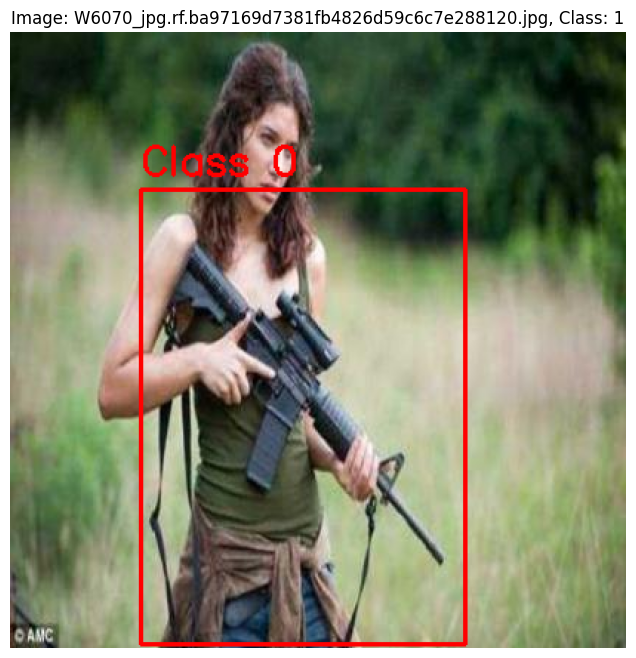

In [4]:
import os
import random
import cv2
import matplotlib.pyplot as plt

# Set the path to your images and labels directories
# Set the path to your images and labels directories
image_folder = "/home/research/Kilsar_Sentinal/Data/WeSecure/train/images"
label_folder = "/home/research/Kilsar_Sentinal/Data/WeSecure/train/labels"

# Function to draw bounding boxes on an image
def draw_bounding_box(image, boxes):
    h, w, _ = image.shape
    for box in boxes:
        cls, x_center, y_center, width, height = box
        # Convert YOLO format to pixel coordinates
        x1 = int((x_center - width / 2) * w)
        y1 = int((y_center - height / 2) * h)
        x2 = int((x_center + width / 2) * w)
        y2 = int((y_center + height / 2) * h)
        
        # Draw the bounding box
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
        
        # Draw the class label (for class '1')
        cv2.putText(image, f"Class {int(cls)}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    return image

# Function to read YOLO label files and handle class as an integer
def read_yolo_labels(label_file):
    boxes = []
    if os.path.exists(label_file):
        with open(label_file, 'r') as f:
            for line in f.readlines():
                parts = line.strip().split()
                cls = int(parts[0])  # Class as integer (instead of string)
                box = list(map(float, parts[1:]))  # The rest are the box coordinates
                boxes.append([cls] + box)
    return boxes

# Load a random sample of images containing class 1 and display them
def visualize_class_1_samples(image_folder, label_folder, num_samples=10 , class_no=0):
    image_files = [f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
    random_samples = random.sample(image_files, min(num_samples, len(image_files)))

    for img_file in random_samples:
        image_path = os.path.join(image_folder, img_file)
        label_path = os.path.join(label_folder, os.path.splitext(img_file)[0] + '.txt')

        # Check if both image and label file exist
        if not os.path.exists(image_path):
            print(f"Image {image_path} not found, skipping.")
            continue
        if not os.path.exists(label_path):
            print(f"Label {label_path} not found, skipping.")
            continue

        # Read YOLO label file
        boxes = read_yolo_labels(label_path)

        # Filter boxes for class '1' (integer comparison)
        boxes_class_1 = [box for box in boxes if box[0] == class_no]
        
        # If class '1' is present, proceed to visualize
        if boxes_class_1:
            # Read image
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib

            # Draw bounding boxes for class '1'
            image_with_boxes = draw_bounding_box(image, boxes_class_1)

            # Display image with bounding boxes
            plt.figure(figsize=(8, 8))
            plt.imshow(image_with_boxes)
            plt.title(f"Image: {img_file}, Class: 1")
            plt.axis('off')
            plt.show()

# Run the visualization for class '1' only
visualize_class_1_samples(image_folder, label_folder, num_samples=10000 , class_no=0 )
